In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import random 
import stormeunice as eun
import sys
import matplotlib.transforms as mtransforms
import scipy as sc

sns.set_theme(style="white")
sns.set_style("white")

sys.path.append('/home/e/ermis/moarpalettes')
from moarpalettes import get_palette

random.seed(10)

In [2]:
def resampleTime(mem_fields, time_ref, resample_freq):

        # get start / end times for properly calculating the maximum fields (taking into account the different preproc times in IFS)
        time_intersection = sorted(list(set(mem_fields.time.values).intersection(time_ref.time.values)))
        time_start = time_intersection[0]-pd.Timedelta('{}h 59m'.format(resample_freq-1))
        time_end = time_intersection[-1]

        # get the instantaneous fields + wind speeds
        mem_fields_out = mem_fields.copy()
        
        # get the maximum fields, taking into account the different preproc times
        if 'fg10' in mem_fields.data_vars:
                fg10_field_out = mem_fields.fg10.sel(time=slice(time_start,time_end)).resample(time='{}h'.format(resample_freq), # resampling freq in hours
                                                                                        label='right',
                                                                                        closed='right',
                                                                                        base=0).max(dim='time')
                mem_fields_out['fg10'] = fg10_field_out

        if 'ws100' in mem_fields.data_vars:
                ws100_field_out = mem_fields.ws100.sel(time=slice(time_start,time_end)).resample(time='{}h'.format(resample_freq), # resampling freq in hours
                                                                                        label='right',
                                                                                        closed='right',
                                                                                        base=0).mean(dim='time')
                mem_fields_out['ws100'] = ws100_field_out

        return mem_fields_out

# Import data

In [3]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60

In [4]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]

In [5]:
# ERA5
era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()
era5_PRES = era5_2022.msl.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()

In [6]:
inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
experiments = ['pi', 'curr', 'incr']
eps = {}
for inidate in inidates:
    eps[inidate] = eun.data.Data.get_eps_data(experiments, inidate = inidate)

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2no_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2no_2022-02-14

In [7]:
# Calculate wind speeds from zonal and meridional speeds
eps = {key_ini : {key : eun.data.Data.get_eps_windpseeds(val) for (key,val) in val_ini.items()} for (key_ini, val_ini) in eps.items()}

In [8]:
land = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc')
land = land.assign(unknown = land.sst.where(land.sst<277).sel(time = '2022-02-18 12'))

# Storm severity index (SSI)

Here, we use the definition proposed by Leckebusch et al. 2018 which is dependent on the cube of the wind speeds, the duration and the affected area.
$$ SSI_{T, K} = \sum_t^T \sum_k^K \Big[ \Big( \max{(0, \frac{v_{k,t}}{v_{Perc, k}}-1)}\Big)^3 \times A_k\Big].  $$

For this definition, we first need to calculate the 98th percentile of wind speeds. The threshold for each gridbox is determined on the basis of the 10 preceding years of ERA5, assuming a stationary climate.

# Functions for SSI calculations

In [9]:
def calcArea(lat, lon): 
    degToRad = np.pi / 180
    diffLat, diffLon = -np.diff(lat).mean(), np.diff(lon).mean()
    llat, llon = np.meshgrid(lat,lon)
    llatHalf, llonHalf = (llat+diffLat/2)*degToRad, (llon+diffLon/2)*degToRad
    radius = 6371
    areas = radius**2 * np.diff(llonHalf, axis = 0)[:,:-1] * -((np.cos(llatHalf[:,:-1]) - np.cos(llatHalf[:,1:])))[:-1,:]
    return np.transpose(areas)

In [10]:
def maskOcean(dataset, mask):
    maskedDataset = dataset.where(mask.unknown.notnull, drop = False)
    return(maskedDataset)

In [11]:
def calcSSI(perc98, forecast, type = 'gust', mask = True):

    temp = []
    areas = calcArea(forecast.latitude.values, forecast.longitude.values)

    if mask:
        # land = xr.open_dataset('topo_land.grb')
        land = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc')
        land = land.assign(unknown = land.sst.where(land.sst<277).sel(time = '2022-02-18 12'))

    for time in forecast.time:

        if mask:
            forecastStep = maskOcean(forecast.sel(time = time), land)
        else:
            forecastStep = forecast.sel(time = time)

        if type == 'gust':
            windMax = forecastStep.where((forecastStep.fg10/perc98.fg10-1)**3> 0).fg10.values[1:,1:]
        elif type == 'speed':
            windMax = forecastStep.where((forecastStep.ws100/perc98.ws100-1)**3> 0).fg10.values[1:,1:]
        else:
            raise(ValueError("Type should be one of speed or gust"))
        
        temp.append(np.nansum(np.multiply(windMax, areas)))
        ssi = np.nansum(temp)
    return ssi

# SSI with masked oceans

In [12]:
era5_windspeeds_98perc = eun.data.Data.get_era_98thperc_winds(height = 100)
era5_windgusts_98perc = eun.data.Data.get_era_98thperc_gusts()

In [13]:
# Calculate SSI based on wind gusts
resampling_freq = 3 # resampling frequency for wind speeds and gusts in hours
timeref = eps[inidate]['pi'].sel(number = 1)
ssiGust = {}
for inidate in inidates:
    ssiGust[inidate] = {}
    for experiment in experiments:
        ssiGust[inidate][experiment] = []
        for mem in range(51):
            ssiGust[inidate][experiment].append(calcSSI(era5_windgusts_98perc.sel(latitude = slice(uk[3], uk[2]), longitude = slice(uk[0], uk[1])), 
                                            resampleTime(eps[inidate][experiment].sel(time = slice('2022-02-18 00', '2022-02-18 23'), number = mem, latitude = slice(uk[3], uk[2]), longitude = slice(uk[0], uk[1])),timeref, resampling_freq), 
                                            mask = True))

In [ ]:
# Calculate ERA5 SSI for Feb 18th
ssi_ERA = calcSSI(era5_windgusts_98perc.sel(latitude = slice(uk[3], uk[2]), longitude = slice(uk[0], uk[1])), 
                  resampleTime(era5_2022.sel(time = slice('2022-02-18 00', '2022-02-18 23'), latitude = slice(uk[3], uk[2]), longitude = slice(uk[0], uk[1])),timeref, resampling_freq), 
                  mask=True)

In [ ]:
ssi_ERA

44084661.37573044

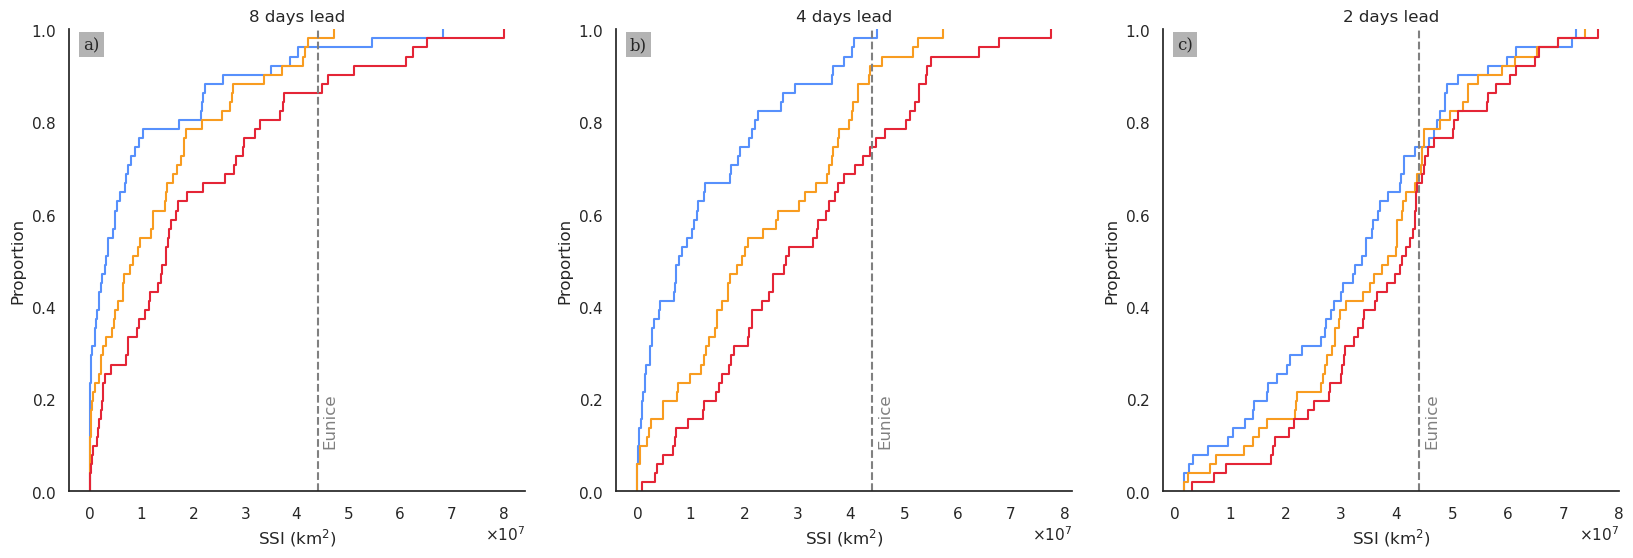

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols =3, figsize = (20,6))
lead_times = ['8 days lead', '4 days lead', '2 days lead']
labels = ['a)', 'b)', 'c)']
fs = 18

for i, inidate in enumerate(inidates): 
    for e, experiment in enumerate(experiments): 
        sns.ecdfplot(ssiGust[inidate][experiment], label = experiment, ax = (ax1, ax2, ax3)[i], color = get_palette.Petroff6().to_sn_palette()[e])

# -------------------------------------------------------

ax1.set_xlabel(r'SSI (km$^2$)', fontsize=fs-3)
ax1.set_ylabel('Proportion of ensemble', fontsize=fs-3)
ax1.set_title(lead_times[0], fontsize=fs)
ax1.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))
ax1.axvline(ssi_ERA, linestyle='dashed', color='grey')
ax1.text(ssi_ERA+1000000, 0.1, 'Eunice (ERA5)', color='grey', rotation='vertical', fontsize=fs)

# subplot label
trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax1.text(0.0, 1.0, labels[0], transform=ax1.transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# -------------------------------------------------------

ax2.set_xlabel(r'SSI (km$^2$)', fontsize=fs-2)
ax2.set_ylabel('Proportion of ensemble', fontsize=fs-3)
ax2.set_title(lead_times[1], fontsize=fs)
ax2.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))
ax2.axvline(ssi_ERA, linestyle='dashed', color='grey')
ax2.text(ssi_ERA+1000000, 0.1, 'Eunice (ERA5)', color='grey', rotation='vertical', fontsize=fs)

ax2.text(0.0, 1.0, labels[1], transform=ax2.transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# -------------------------------------------------------

ax3.set_xlabel(r'SSI (km$^2$)', fontsize=fs-3)
ax2.set_ylabel('Proportion of ensemble', fontsize=fs-3)
ax3.set_title(lead_times[2], fontsize=fs)
ax3.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))   
ax3.axvline(ssi_ERA, linestyle='dashed', color='grey') 
ax3.text(ssi_ERA+1000000, 0.1, 'Eunice (ERA5)', color='grey', rotation='vertical', fontsize=fs)

ax3.text(0.0, 1.0, labels[2], transform=ax3.transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# -------------------------------------------------------

sns.despine()
plt.legend(['pi', 'curr', 'fut'], title = "experiment", fontsize=fs-3, frameon=False, title_fontsize=fs)

plt.savefig('figures/PAPER2_SSI_ecdf.png')
plt.savefig('figures/PAPER2_SSI_ecdf.pdf')
plt.show()

# Significance tests

In [17]:
print('8 days lead')
ini = '2022-02-10'
print('PI cs CURR: ', sc.stats.kstest(ssiGust[ini]['pi'], ssiGust[ini]['curr']).pvalue)
print('PI cs INCR: ', sc.stats.kstest(ssiGust[ini]['pi'], ssiGust[ini]['incr']).pvalue)
print('CURR cs INCR ', sc.stats.kstest(ssiGust[ini]['curr'], ssiGust[ini]['incr']).pvalue)

8 days lead
PI cs CURR:  0.11896879781089878
PI cs INCR:  0.0002962539414562207
CURR cs INCR  0.2827032230516193


In [18]:
print('4 days lead')
ini = '2022-02-14'
print('PI cs CURR: ', sc.stats.kstest(ssiGust[ini]['pi'], ssiGust[ini]['curr']).pvalue)
print('PI cs INCR: ', sc.stats.kstest(ssiGust[ini]['pi'], ssiGust[ini]['incr']).pvalue)
print('CURR cs INCR ', sc.stats.kstest(ssiGust[ini]['curr'], ssiGust[ini]['incr']).pvalue)

4 days lead
PI cs CURR:  0.0015266634563284502
PI cs INCR:  1.7812528727320293e-05
CURR cs INCR  0.11896879781089878


In [19]:
print('2 days lead')
ini = '2022-02-16'
print('PI cs CURR: ', sc.stats.kstest(ssiGust[ini]['pi'], ssiGust[ini]['curr']).pvalue)
print('PI cs INCR: ', sc.stats.kstest(ssiGust[ini]['pi'], ssiGust[ini]['incr']).pvalue)
print('CURR cs INCR ', sc.stats.kstest(ssiGust[ini]['curr'], ssiGust[ini]['incr']).pvalue)

2 days lead
PI cs CURR:  0.5615639086437574
PI cs INCR:  0.1872821633138174
CURR cs INCR  0.5615639086437574


# Increase in severity

In [20]:
rr_pivincr = {key_ini: np.ma.masked_invalid([ssiGust[key_ini]['incr'][i]/ssiGust[key_ini]['pi'][i] for i in range(len(ssiGust[key_ini]['pi']))]) for (key_ini, val_ini) in ssiGust.items()}
rr_currvincr = {key_ini: np.ma.masked_invalid([ssiGust[key_ini]['incr'][i]/ssiGust[key_ini]['curr'][i] for i in range(len(ssiGust[key_ini]['curr']))]) for (key_ini, val_ini) in ssiGust.items()}

/tmp/user/27529/ipykernel_1583601/4184820294.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  rr_pivincr = {key_ini: np.ma.masked_invalid([ssiGust[key_ini]['incr'][i]/ssiGust[key_ini]['pi'][i] for i in range(len(ssiGust[key_ini]['pi']))]) for (key_ini, val_ini) in ssiGust.items()}
/tmp/user/27529/ipykernel_1583601/4184820294.py:1: RuntimeWarning: invalid value encountered in double_scalars
  rr_pivincr = {key_ini: np.ma.masked_invalid([ssiGust[key_ini]['incr'][i]/ssiGust[key_ini]['pi'][i] for i in range(len(ssiGust[key_ini]['pi']))]) for (key_ini, val_ini) in ssiGust.items()}
/tmp/user/27529/ipykernel_1583601/4184820294.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  rr_currvincr = {key_ini: np.ma.masked_invalid([ssiGust[key_ini]['incr'][i]/ssiGust[key_ini]['curr'][i] for i in range(len(ssiGust[key_ini]['curr']))]) for (key_ini, val_ini) in ssiGust.items()}
/tmp/user/27529/ipykernel_1583601/4184820294.py:2: RuntimeWarning: invalid value encounte

In [21]:
rr_currvincr = {key_ini : val_ini[~np.isinf(val_ini)]for (key_ini, val_ini) in rr_currvincr.items()}
rr_currvincr = {key_ini : val_ini[~np.isnan(val_ini)]for (key_ini, val_ini) in rr_currvincr.items()}

rr_pivincr = {key_ini : val_ini[~np.isinf(val_ini)]for (key_ini, val_ini) in rr_pivincr.items()}
rr_pivincr = {key_ini : val_ini[~np.isnan(val_ini)]for (key_ini, val_ini) in rr_pivincr.items()}

In [22]:
# sc.stats.binom(51, 0.5).cdf(sum(np.array(rr_currvincr['2022-02-10'])>1)) # conf level
# bootstrap 
bootstrap_currvincr = {key_ini : np.random.choice(rr_currvincr[key_ini], size=10000) for (key_ini, val_ini) in ssiGust.items()}
ci_currvincr = {key_ini: [np.nanpercentile(bootstrap_currvincr[key_ini], 5), np.nanpercentile(bootstrap_currvincr[key_ini], 95)] for (key_ini, val_ini) in ssiGust.items()}

bootstrap_pivincr = {key_ini : np.random.choice(rr_pivincr[key_ini], size=10000) for (key_ini, val_ini) in ssiGust.items()}
ci_pivincr = {key_ini: [np.nanpercentile(bootstrap_pivincr[key_ini], 5), np.nanpercentile(bootstrap_pivincr[key_ini], 95)] for (key_ini, val_ini) in ssiGust.items()}

In [23]:
print('pi vs incr')
print(np.nanmean(rr_pivincr['2022-02-10']))
print(np.nanmean(rr_pivincr['2022-02-14']))
print(np.nanmean(rr_pivincr['2022-02-16']))

print('\n curr vs incr')
print(np.nanmean(rr_currvincr['2022-02-10']))
print(np.nanmean(rr_currvincr['2022-02-14']))
print(np.nanmean(rr_currvincr['2022-02-16']))


pi vs incr
73.64643806529045
18.38139021235858
1.6042825197728254

 curr vs incr
13.098630590685834
7.384165478150206
1.1912027049044922


In [24]:
print('pi vs incr')
print(ci_pivincr['2022-02-10'])
print(ci_pivincr['2022-02-14'])
print(ci_pivincr['2022-02-16'])

print('\n curr vs incr')
print(ci_currvincr['2022-02-10'])
print(ci_currvincr['2022-02-14'])
print(ci_currvincr['2022-02-16'])

pi vs incr
[0.0724190836253019, 235.04440736240963]
[0.7024252616121314, 71.88328968485497]
[0.8979690282228341, 2.827465805279528]

 curr vs incr
[0.09620112307354477, 73.39263533656683]
[0.8158159470356097, 14.045720347489837]
[0.9699495620713142, 1.6532959425424028]


# Risk ratio

In [25]:
def weibull_cdf(x, shape, scale):
    y = 1 - np.exp(-(shape*x)**scale)
    return y

def ecdf(data):
    x, counts = np.unique(data, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def invert_weibull_cdf(y, shape, scale):
    return ((np.log(1/(1-y)))/shape)**(1/scale)

/tmp/user/27529/ipykernel_1583601/2701524598.py:2: RuntimeWarning: divide by zero encountered in power
  y = 1 - np.exp(-(shape*x)**scale)
/tmp/user/27529/ipykernel_1583601/2701524598.py:2: RuntimeWarning: invalid value encountered in power
  y = 1 - np.exp(-(shape*x)**scale)


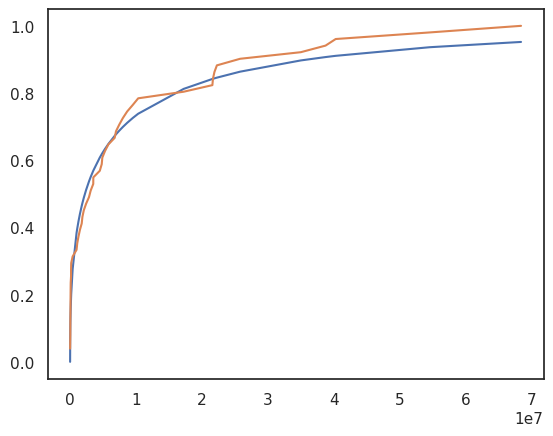

In [57]:
# data = [x/10000000 for x in ssiGust['2022-02-10']['pi']]
data = ssiGust['2022-02-10']['pi']
x, y = ecdf(data)
bestfit, covar = sc.optimize.curve_fit(weibull_cdf, x, y, p0=[1500000, 0.1])

plt.plot(x, weibull_cdf(x, *bestfit))
plt.plot(x,y)

In [58]:
covar

array([[8.68151257e-17, 2.08503691e-11],
       [2.08503691e-11, 2.23471607e-04]])

In [59]:
bestfit

array([1.90740913e-07, 4.32516781e-01])

/tmp/user/27529/ipykernel_1583601/2701524598.py:2: RuntimeWarning: invalid value encountered in power
  y = 1 - np.exp(-(shape*x)**scale)
/tmp/user/27529/ipykernel_1583601/2701524598.py:2: RuntimeWarning: invalid value encountered in power
  y = 1 - np.exp(-(shape*x)**scale)
/tmp/user/27529/ipykernel_1583601/2701524598.py:2: RuntimeWarning: invalid value encountered in power
  y = 1 - np.exp(-(shape*x)**scale)
/tmp/user/27529/ipykernel_1583601/2701524598.py:2: RuntimeWarning: invalid value encountered in power
  y = 1 - np.exp(-(shape*x)**scale)
/tmp/user/27529/ipykernel_1583601/2701524598.py:2: RuntimeWarning: invalid value encountered in power
  y = 1 - np.exp(-(shape*x)**scale)
/tmp/user/27529/ipykernel_1583601/2701524598.py:2: RuntimeWarning: invalid value encountered in power
  y = 1 - np.exp(-(shape*x)**scale)


(0.0, 80000000.0)

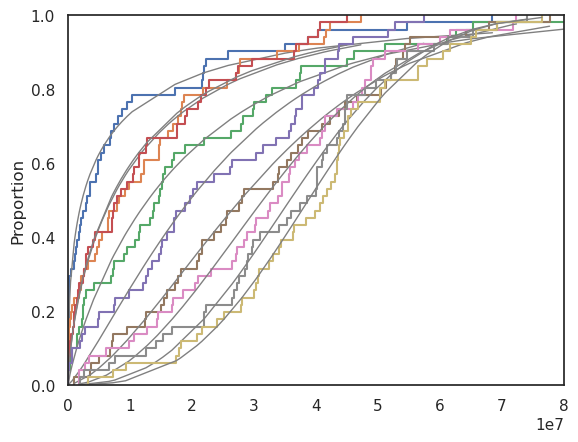

In [100]:
# fit Weibull distributions to SSI values and determine the probability of exceedance

p = {}
upper_bound = {}
lower_bound = {}
for ini in inidates:
    p[ini] = {}
    upper_bound[ini] = {}
    lower_bound[ini] = {}
    for exp in experiments:
        data = ssiGust[ini][exp]
        x, y = ecdf(data)
        bestfit, covar = sc.optimize.curve_fit(weibull_cdf, x, y, p0=[0.00000012, 0.4])

        z = np.linspace(invert_weibull_cdf(0.01, *bestfit), invert_weibull_cdf(0.99, *bestfit), 1000)
        sns.ecdfplot(ssiGust[ini][exp])
        plt.plot(x, weibull_cdf(x, *bestfit), color = 'grey', lw = 1)
    
        # calculate uncertainty in the fit
        sigma = np.sqrt(np.diagonal(covar))
        lower_bound[ini][exp] = 1 - weibull_cdf(ssi_ERA, *(bestfit + sigma))
        upper_bound[ini][exp] = 1 - weibull_cdf(ssi_ERA, *(bestfit - sigma))

        p[ini][exp] = 1 - weibull_cdf(ssi_ERA, *bestfit)
plt.xlim(0, 80000000)

In [101]:
# fit Weibull distributions to SSI values and determine the probability of exceedance

# p = {}
# for ini in inidates:
#     p[ini] = {}
#     for exp in experiments:
#         data = ssiGust[ini][exp]
#         bestfit= sc.stats.weibull_min.fit(data, floc=20000)
#         rv_fit = sc.stats.weibull_min(*bestfit)  # frozen pdf

#         x = np.linspace(rv_fit.ppf(0.01), rv_fit.ppf(0.99), 1000)
#         sns.lineplot(x = x, y= rv_fit.cdf(x), color = 'grey', lw = 1)
#         sns.ecdfplot(ssiGust[ini][exp])

#         p[ini][exp] =  1 - rv_fit.cdf(ssi_ERA)

# plt.xlim(0, 80000000)

In [104]:
for ini in inidates:
    print('INCR/PI \t', ini, '\t', p[ini]['incr']/p[ini]['pi'], '\t (', lower_bound[ini]['incr']/upper_bound[ini]['pi'], upper_bound[ini]['incr']/lower_bound[ini]['pi'], ')')

    print('CURR/PI \t', ini, '\t', p[ini]['curr']/p[ini]['pi'], '\t (', lower_bound[ini]['curr']/upper_bound[ini]['pi'], upper_bound[ini]['curr']/lower_bound[ini]['pi'], ')')

    print('INCR/CURR \t', ini, '\t', p[ini]['incr']/p[ini]['curr'], '\t (', lower_bound[ini]['incr']/upper_bound[ini]['curr'], upper_bound[ini]['incr']/lower_bound[ini]['curr'], ')')

INCR/PI 	 2022-02-10 	 1.7178580803921986 	 ( 1.3887086241878652 2.1318105620419607 )
CURR/PI 	 2022-02-10 	 1.1120447584599307 	 ( 0.828690071550941 1.4840199099147198 )
INCR/CURR 	 2022-02-10 	 1.5447742254288919 	 ( 1.2211890263438498 1.9712648859146364 )
INCR/PI 	 2022-02-14 	 2.848485478588505 	 ( 2.4893809687715063 3.2742388441223627 )
CURR/PI 	 2022-02-14 	 1.8558560247487343 	 ( 1.5096090553906263 2.2757116332295504 )
INCR/CURR 	 2022-02-14 	 1.5348633948984074 	 ( 1.3532977024617403 1.753180595496472 )
INCR/PI 	 2022-02-16 	 1.4363410950147026 	 ( 1.3544087941496308 1.5255828121825603 )
CURR/PI 	 2022-02-16 	 1.2035842090017668 	 ( 1.1228763974816118 1.2912487594152628 )
INCR/CURR 	 2022-02-16 	 1.1933864571104507 	 ( 1.1395524688182614 1.2505738849064343 )
